In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


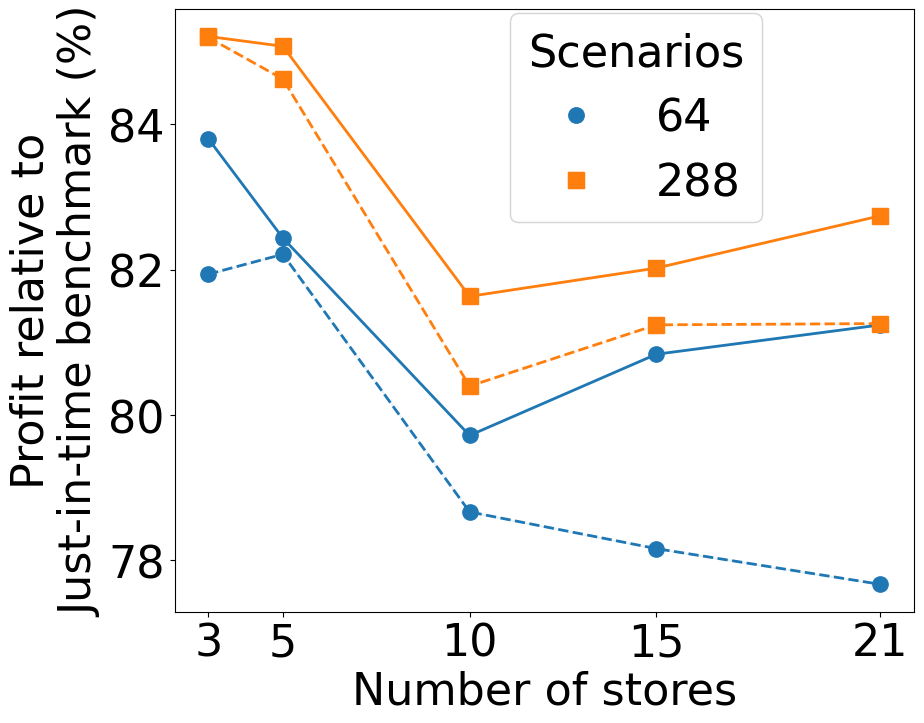

In [24]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_real_one_warehouse_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if 'master' in reference_row:
        out_row['master'] = reference_row['master']

def default_condition_setter(condition_name):
    return None

color_scheme = {
    64: "#1f77b4",     # Blue
    288: "#ff7f0e",    # Orange
}

marker_scheme = {
    64: "o",           # Circle
    288: "s",          # Rectangle (square)
}

linestyle_scheme = {
    "GNN": "-",        # Solid
    "Vanilla": "--",   # Dashed
}

architectures = {
    "Vanilla": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_real',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

store_counts = [3, 5, 10, 15, 21]
base_config = "one_warehouse_21_real_lost_demand"
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_sizes = [64, 288]

dfs = []
jit_dfs = []

for arch_name, path in architectures.items():
    for sample_size in sample_sizes:
        if arch_name == "Just-In-Time":
            jit_df = results_interpretor.make_table(
                {1: path},
                {'n_stores': store_counts, 'train_dev_sample_and_batch_size': [sample_size]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25
            )
            if not jit_df.empty:
                jit_df.insert(2, 'Architecture Class', arch_name)
                jit_df.insert(1, 'hyperparam_name', arch_name)
                jit_df['train_dev_sample_and_batch_size'] = sample_size
                jit_dfs.append(jit_df)
        else:
            df = results_interpretor.make_table(
                {1: path},
                {
                    'train_dev_sample_and_batch_size': [sample_size],
                    'n_stores': store_counts,
                    'test_n_samples': [sample_size]
                },
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25
            )
            if df.empty:
                continue

            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()

jit_losses = {}
for n_stores in store_counts:
    for sample_size in sample_sizes:
        jit_data = jit_df[(jit_df['n_stores'] == n_stores) & 
                          (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
        if not jit_data.empty:
            jit_loss = jit_data['Test Loss'].min()
            jit_losses[(n_stores, sample_size)] = jit_loss

stats_by_arch_sample_and_stores = {}
for n_stores in store_counts:
    stores_data = df[df['n_stores'] == n_stores].copy()
    if stores_data.empty:
        continue
    for sample_size in sample_sizes:
        if (n_stores, sample_size) not in jit_losses:
            continue
        jit_loss = jit_losses[(n_stores, sample_size)]
        sample_data = stores_data[stores_data['train_dev_sample_and_batch_size'] == sample_size].copy()
        if sample_data.empty:
            continue
        sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
        for arch in sample_data['Architecture Class'].unique():
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []
            arch_data = sample_data[sample_data['Architecture Class'] == arch]
            if not arch_data.empty:
                ratios = arch_data['Loss Ratio'].to_numpy()
                mean_percentage = np.mean(ratios * 100)
                std_percentage = np.std(ratios * 100)
                ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_stores,
                    'mean_percentage': mean_percentage,
                    'ci_lower': mean_percentage - ci_95,
                    'ci_upper': mean_percentage + ci_95
                })

FONTSIZE = 32
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch in ["GNN", "Vanilla"]:
    for sample_size in sample_sizes:
        key = (arch, sample_size)
        stats = stats_by_arch_sample_and_stores.get(key, [])
        stats_df = pd.DataFrame(stats)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_stores')
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_percentage_array = stats_df['mean_percentage'].to_numpy()
            ci_lower_array = stats_df['ci_lower'].to_numpy()
            ci_upper_array = stats_df['ci_upper'].to_numpy()
            plt.plot(
                n_stores_array,
                mean_percentage_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=11,
                linewidth=2,
                label=None
            )
            plt.fill_between(
                n_stores_array,
                ci_lower_array,
                ci_upper_array,
                color=color_scheme[sample_size],
                alpha=0.1
            )

# Legend handles: GNN above Vanilla, and for each, from low to high samples
arch_order = ["GNN", "Vanilla"]
sample_order = [64, 288]

arch_lines = [
    plt.Line2D(
        [0], [0],
        color='black',
        linestyle=linestyle_scheme[arch],
        linewidth=2,
        label=arch
    )
    for arch in arch_order
]

sample_patches = [
    plt.Line2D(
        [0], [0],
        color=color_scheme[size],
        marker=marker_scheme[size],
        linestyle='none',
        markersize=11,
        linewidth=2,
        label=f'{size}'
    )
    for size in sample_order
]

plt.xlabel('Number of stores', fontsize=FONTSIZE)
plt.ylabel('Profit relative to\nJust-in-time benchmark (%)', fontsize=FONTSIZE)
plt.xticks(store_counts, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# legend1 = plt.legend(
#     handles=arch_lines,
#     bbox_to_anchor=(0.99, 1),
#     loc='upper right',
#     fontsize=FONTSIZE,
#     borderaxespad=0.1,
#     framealpha=0.6
# )
# plt.gca().add_artist(legend1)

legend2 = plt.legend(
    handles=sample_patches,
    title='Scenarios',
    # bbox_to_anchor=(0.56, 1),
    bbox_to_anchor=(0.8, 1),
    loc='upper right',
    fontsize=FONTSIZE,
    borderaxespad=0.1,
    framealpha=0.6
)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.tight_layout()
plt.savefig("/user/ml4723/Prj/NIC/Plots/sample_efficiency_OWMS_real.pdf", bbox_inches='tight')
plt.show()

In [31]:
import numpy as np

# Define columns for the new table
columns = [
    "Number of stores",
    "Training scenarios (#)",
    "Architecture Class",
    "Learning rate",
    "Units per layer (#)",
    "Train profit",
    "Dev profit",
    "Test profit",
    "Test profit relative to Just-in-time (%)"
]

# Prepare mapping for architecture class sorting
arch_sort_map = {"GNN": 0, "Vanilla": 1}

# Prepare new DataFrame rows
new_rows = []
for idx, row in df.iterrows():
    n_stores = row.get("n_stores", row.get("# of stores", "-"))
    sample_size = row.get("train_dev_sample_and_batch_size", "-")
    arch = row.get("Architecture Class", row.get("hyperparam_name", "-"))
    if arch == "Data-Driven NN":
        arch = "Vanilla"
    learning_rate = row.get("Learning Rate", row.get("learning_rate", "-"))
    master = row.get("master", "-")
    train_loss = -row.get("Train Loss", row.get("train_loss(at best_dev_loss)", "-"))
    dev_loss = -row.get("Dev Loss", row.get("dev_loss(at best_dev_loss)", "-"))
    test_loss = -row.get("Test Loss", row.get("test_loss(at best_dev_loss)", "-"))
    # Calculate profit relative to JIT
    if (n_stores, sample_size) in jit_losses and not pd.isna(test_loss):
        jit_loss = -jit_losses[n_stores, sample_size]
        rel_gap = test_loss / jit_loss * 100
    else:
        rel_gap = "-"
    # Round values
    def safe_round(x):
        try:
            return round(float(x), 2)
        except:
            return "-"
    train_loss = safe_round(train_loss)
    dev_loss = safe_round(dev_loss)
    test_loss = safe_round(test_loss)
    rel_gap = safe_round(rel_gap) if rel_gap != "-" else "-"
    # Fill missing
    master = int(master) if master != "-" and not pd.isna(master) else "-"
    sample_size = int(sample_size) if sample_size != "-" and not pd.isna(sample_size) else "-"
    new_rows.append({
        "Number of stores": n_stores,
        "Training scenarios (#)": sample_size,
        "Architecture Class": arch,
        "Learning rate": learning_rate,
        "Units per layer (#)": master,
        "Train profit": train_loss,
        "Dev profit": dev_loss,
        "Test profit": test_loss,
        "Test profit relative to Just-in-time (%)": rel_gap
    })

new_df = pd.DataFrame(new_rows, columns=columns)

# For each number of stores, find the row with the lowest (unrounded) test loss and wrap it in \textbf{}
for n_stores in new_df["Number of stores"].unique():
    mask = new_df["Number of stores"] == n_stores
    # Find original test losses for this n_stores
    orig_mask = (df["n_stores"] == n_stores)
    test_losses = -df.loc[orig_mask, "Test Loss"]
    # Only consider non-NaN
    if not test_losses.dropna().empty:
        max_idx = test_losses.astype(float).idxmax()
        max_test_loss = -df.loc[max_idx, "Test Loss"]
        # Find corresponding row in new_df
        for i in new_df[mask].index:
            if (abs(float(new_df.loc[i, "Test profit"]) - float(max_test_loss)) < 0.01):
                # Wrap in \textbf{}
                val = new_df.loc[i, "Test profit"]
                if val != "-":
                    new_df.loc[i, "Test profit"] = r"\textbf{" + str(val) + "}"
                break

# Sort: by Number of stores, then Training scenarios, then Architecture Class (GNN first, then Vanilla)
def arch_sort_key(x):
    return arch_sort_map.get(x, 99)

# First, sort by Number of stores and Training scenarios (#)
new_df = new_df.sort_values(
    by=["Number of stores", "Training scenarios (#)"]
)

# Then, within each group, sort Architecture Class as GNN then Vanilla
def sort_arch_group(df_group):
    return df_group.sort_values(by="Architecture Class", key=lambda x: x.map(arch_sort_map))

new_df = new_df.groupby(["Number of stores", "Training scenarios (#)"], group_keys=False).apply(sort_arch_group)

print(new_df.to_string(index=False))

[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/typing_extensions.py", line 844, in <module>
    class SupportsAbs(P

 Number of stores  Training scenarios (#) Architecture Class  Learning rate Units per layer (#)  Train profit  Dev profit     Test profit  Test profit relative to Just-in-time (%)
                3                      64                GNN         0.0100                   -        634.84      618.80          545.59                                     83.81
                3                      64            Vanilla         0.0010                 128        641.36      616.52          533.44                                     81.94
                3                     288                GNN         0.0010                   -        750.00      703.00 \textbf{638.42}                                     85.21
                3                     288            Vanilla         0.0010                 128        747.14      702.70          638.32                                     85.20
                5                      64                GNN         0.0001                   -     

/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_98386/695146820.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{638.42}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df.loc[i, "Test profit"] = r"\textbf{" + str(val) + "}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_98386/695146820.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = new_df.groupby(["Number of stores", "Training scenarios (#)"], group_keys=False).apply(sort_arch_group)


In [18]:
new_df

,Number of stores,Training scenarios (#),Architecture Class,Learning rate,Units per layer (#),Train profit,Dev profit,Test profit,Test profit relative to Just-in-time (%)
0,3,64,Vanilla,0.00,128,641.36,616.52,533.44,81.94
1,5,64,Vanilla,0.00,256,571.07,545.06,483.51,82.21
2,10,64,Vanilla,0.00,512,474.64,447.17,412.49,78.67
3,15,64,Vanilla,0.00,128,518.31,481.53,427.32,78.16
4,21,64,Vanilla,0.00,512,612.19,563.63,494.85,77.67
5,3,288,Vanilla,0.00,128,747.14,702.70,638.32,85.20
6,5,288,Vanilla,0.00,128,661.25,623.18,575.47,84.63
7,10,288,Vanilla,0.00,128,523.04,492.34,459.88,80.40
8,15,288,Vanilla,0.00,128,558.76,523.37,479.68,81.24
9,21,288,Vanilla,0.00,256,664.44,624.07,569.37,81.26


In [12]:
jit_losses

{(3, 64): -651.0142609126984,
 (3, 288): -749.2100418871253,
 (5, 64): -588.1160714285714,
 (5, 288): -680.0222883597884,
 (10, 64): -524.3415550595238,
 (10, 288): -571.9902116402117,
 (15, 64): -546.7113095238095,
 (15, 288): -590.4260141093474,
 (21, 64): -637.1080640589569,
 (21, 288): -700.6742252456538}

In [11]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,n_stores,test_n_samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,master
0,1,Data-Driven NN,64,Data-Driven NN,3,64,0.0010,-641.356606,-616.516183,-533.436074,27,/Users/minuk.lee/Downloads/Neural_inventory_co...,128.0
1,1,Data-Driven NN,64,Data-Driven NN,5,64,0.0010,-571.067880,-545.059710,-483.510379,26,/Users/minuk.lee/Downloads/Neural_inventory_co...,256.0
2,1,Data-Driven NN,64,Data-Driven NN,10,64,0.0010,-474.635127,-447.168080,-412.486421,27,/Users/minuk.lee/Downloads/Neural_inventory_co...,512.0
3,1,Data-Driven NN,64,Data-Driven NN,15,64,0.0010,-518.305169,-481.530952,-427.322073,26,/Users/minuk.lee/Downloads/Neural_inventory_co...,128.0
4,1,Data-Driven NN,64,Data-Driven NN,21,64,0.0001,-612.190476,-563.625779,-494.848143,25,/Users/minuk.lee/Downloads/Neural_inventory_co...,512.0
5,1,Data-Driven NN,288,Data-Driven NN,3,288,0.0010,-747.135988,-702.695822,-638.315586,27,/Users/minuk.lee/Downloads/Neural_inventory_co...,128.0
6,1,Data-Driven NN,288,Data-Driven NN,5,288,0.0001,-661.245007,-623.182870,-575.471164,27,/Users/minuk.lee/Downloads/Neural_inventory_co...,128.0
7,1,Data-Driven NN,288,Data-Driven NN,10,288,0.0010,-523.040647,-492.337103,-459.875364,26,/Users/minuk.lee/Downloads/Neural_inventory_co...,128.0
8,1,Data-Driven NN,288,Data-Driven NN,15,288,0.0001,-558.756306,-523.369444,-479.675794,25,/Users/minuk.lee/Downloads/Neural_inventory_co...,128.0
9,1,Data-Driven NN,288,Data-Driven NN,21,288,0.0001,-664.444461,-624.073696,-569.367536,26,/Users/minuk.lee/Downloads/Neural_inventory_co...,256.0
